<a href="https://colab.research.google.com/github/joseluizduarte/simple_neural_net/blob/main/simple_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuração do ambiente

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

path = untar_data(URLs.MNIST)

#hide
Path.BASE_PATH = path

from random import choice

     |████████████████████████████████| 720 kB 7.2 MB/s 
     |████████████████████████████████| 1.2 MB 53.2 MB/s 
     |████████████████████████████████| 186 kB 56.6 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 51 kB 302 kB/s 
Mounted at /content/gdrive


# Classe da rede

In [ ]:
class SimpleNet:

  # Inicia parâmetros
  def init_params(sel, size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

  def __init__(self,dataset_train,dataset_test,features,batch_size=256,learning_rate=1.):
    # Inicia parâmetros
    w1 = self.init_params((28*28,features))
    b1 = self.init_params(features)
    w2 = self.init_params((features,1))
    b2 = self.init_params(1)
    self.params = w1, b1, w2, b2
    # Divisão dos batchs
    self.batch_size = 256
    self.dataloader_train = DataLoader(dataset_train,batch_size=batch_size)
    self.dataloader_test = DataLoader(dataset_test,batch_size=batch_size)
    # Learning rate
    self.learning_rate = learning_rate
    self.last_epoch = 0
    self.last_accuracy = 0

  def model(self, xb):
    w1, b1, w2, b2 = self.params 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

  # Função perda
  def mnist_loss(self, pred, target):
    pred = pred.sigmoid()
    return torch.where(target==1, 1-pred, pred).mean()

  # Cálculo do gradiente
  def calc_gradient(self, x, y, model):
    pred = model(x)
    loss = self.mnist_loss(pred, y)
    loss.backward()

  def train_epoch(self):
    for x, y in self.dataloader_train:
      self.calc_gradient(x, y, self.model)
      epoch_params = []
      for p in self.params:
        p.data -= p.grad*self.learning_rate
        epoch_params.append(p.data)
        p.grad.zero_()
    return epoch_params

  # Calcula a acurácia do batch
  def batch_accuracy(self, x, y):
    pred = x.sigmoid()
    corrects = ( (pred >= 0.5) == y )
    return corrects.float().mean()

  # Validação da época
  def validate_epoch(self):
    accs = [self.batch_accuracy(self.model(x),y) for x, y in self.dataloader_test]
    return round(torch.stack(accs).mean().item(), 5)

  def train_net(self,number_epochs, stop=1):
    for i in range(number_epochs):
      current_epoch = self.last_epoch + 1
      epoch_params = self.train_epoch()
      epoch_accuracy = self.validate_epoch()
      if epoch_accuracy > self.last_accuracy:
        self.best_result = {'epoch': current_epoch, 'accuracy': epoch_accuracy, 'params': epoch_params}
      self.last_epoch = current_epoch
      self.last_accuracy = epoch_accuracy
      print(f"*** Epoch {current_epoch}: ", epoch_accuracy)
      if self.last_accuracy > stop:
        return

  def find_number(self,img):
    w1, b1, w2, b2 = self.best_result['params']
    res = img@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    res = res.sigmoid()
    if res >= 0.5:
      return 0
    else:
      return 5



# Preparação dos dados

In [ ]:
# Seleciona imagens (0 e 5) do dataset
zeros_train = (path/'training'/'0').ls().sorted()
fives_train = (path/'training'/'5').ls().sorted()
zeros_test = (path/'testing'/'0').ls().sorted()
fives_test = (path/'testing'/'5').ls().sorted()

# Cria lista de tensores das imagens
zeros_tensor_train = [tensor(Image.open(o)) for o in zeros_train]
fives_tensor_train = [tensor(Image.open(o)) for o in fives_train]
zeros_tensor_test = [tensor(Image.open(o)) for o in zeros_test]
fives_tensor_test = [tensor(Image.open(o)) for o in fives_test]

print(f"{len(zeros_tensor_train)+len(fives_tensor_train)} imagens para treino ({len(zeros_tensor_train)} de 0's e {len(fives_tensor_train)} de 5's)")
print(f"{len(zeros_tensor_test)+len(fives_tensor_test)} imagens para teste ({len(zeros_tensor_test)} de 0's e {len(fives_tensor_test)} de 5's)")

# Normaliza imagens e cria tensor de tensores
stacked_zeros_train = torch.stack(zeros_tensor_train).float()/255
stacked_fives_train = torch.stack(fives_tensor_train).float()/255
stacked_zeros_test = torch.stack(zeros_tensor_test).float()/255
stacked_fives_test = torch.stack(fives_tensor_test).float()/255

### Configura dataset
## Ground Truth
# 1(True): número 0
# 0(False): número 5
## Train
x_train = torch.cat([stacked_zeros_train,stacked_fives_train]).view(-1,28*28)
y_train = tensor([1]*len(stacked_zeros_train)+[0]*len(stacked_fives_train)).unsqueeze(1)
dataset_train = list(zip(x_train,y_train))
## Test
x_test = torch.cat([stacked_zeros_test,stacked_fives_test]).view(-1,28*28)
y_test = torch.tensor([1]*len(stacked_zeros_test)+[0]*len(stacked_fives_test)).unsqueeze(1)
dataset_test = list(zip(x_test,y_test))



11344 imagens para treino (5923 de 0's e 5421 de 5's)
1872 imagens para teste (980 de 0's e 892 de 5's)


# Redes treinadas

## Rede 1

Features = 20

Batch size = 128

Learning rate = 0.1

In [ ]:
r1 = SimpleNet(dataset_train, dataset_test, features=20, batch_size=128,learning_rate=0.1)
r1.train_net(3000)
r1.best_result['accuracy']

## Rede 2

Features = 30

Batch size = 128

Learning rate = 0.1

In [ ]:
r2 = SimpleNet(dataset_train, dataset_test, features=30, batch_size=128,learning_rate=0.1)
r2.train_net(3000)
r2.best_result['accuracy']

## Rede 3

Features = 50

Batch size = 128

Learning rate = 0.1

In [ ]:
r3 = SimpleNet(dataset_train, dataset_test, features=40, batch_size=128,learning_rate=0.1)
r3.train_net(3000)
r3.best_result['accuracy']

# Aplicação da rede

## Imagem com 0

Número presente na imagem: 0


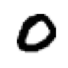

In [50]:
img_0 = choice(stacked_zeros_test)
show_image(img_0)
img_0 = img_0.view(-1,28*28)
print(f"Número presente na imagem: {r3.find_number(img_0)}")

## Imagem com 5

Número presente na imagem: 5


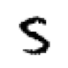

In [52]:
img_5 = choice(stacked_fives_test)
show_image(img_5)
img_5 = img_5.view(-1,28*28)
print(f"Número presente na imagem: {r3.find_number(img_5)}")